# Qiskit simulator backends

Qiskit - IBM library for quantum developers. This is how we install.

In [ ]:
!pip install qiskit

It consists of [few parts](https://github.com/orgs/Qiskit/repositories). Among them are:
- [Terra](https://qiskit.org/documentation/apidoc/terra.html) - basic quantum components.
- [Aer](https://qiskit.org/documentation/apidoc/aer.html) - simulators. You can run a program in multiple ways.
- [Ignis](https://qiskit.org/documentation/apidoc/ignis.html) - hardware verification and quantum error correction.
- [Nature](https://github.com/Qiskit/qiskit-nature) - scientific task solvers.
- [Optimization](https://github.com/Qiskit/qiskit-optimization) - optimizers.
- [Machine Learning](https://github.com/Qiskit/qiskit-machine-learning) - a few ML algorithms.
- [Metal](https://github.com/Qiskit/qiskit-metal) - supercoducting circuits developer toolkit.

Also there are separate finance, chemisty blocks.

Simplest simulated circuit looks like ...

In [1]:
# these are classes to initialize registers
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
# visualization code
from qiskit.visualization import plot_histogram

qr = QuantumRegister(2, 'qbits')
cr = ClassicalRegister(2, 'bits')
qc = QuantumCircuit(qr, cr)

No operations, empty circuit

In [2]:
qc.draw()

qbits_0: 
         
qbits_1: 
         
 bits: 2/

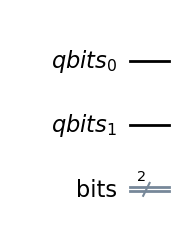

In [3]:
# also with latex
# qc.draw(output='latex')

# with matplotlib
import matplotlib.pyplot as plt
qc.draw(output='mpl')

Let's add 2 gates. $0^{th}$ qubit with get $H$ (Hadamard), and then, we apply $CNOT$ to both, with 0 -- controlling, and 1 -- controlled.

In [4]:
qc.h(qr[0])
qc.cx(qr[0], qr[1])

# also this works
# qc.h(0)
# qc.cx(0, 1)

Draw it with matplotlib now

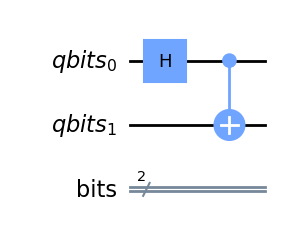

In [5]:
qc.draw(output='mpl')

What about measuring?

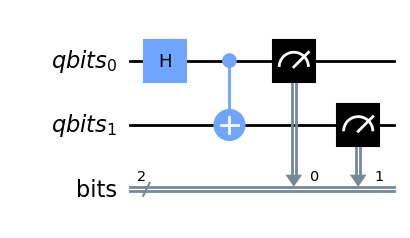

In [6]:
# qc.measure(qr[0], cr[0])
# qc.measure(qr[1], cr[1])
# or even simpler
qc.measure(qr, cr)

qc.draw(output='mpl')

This picture is indeed a quantum program. The only think left is to execute!

There are many simulators, each of them have its own features. Deeper here: https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html

First, we run probabilistic `qasm_simulator`. Do it 1000 times.

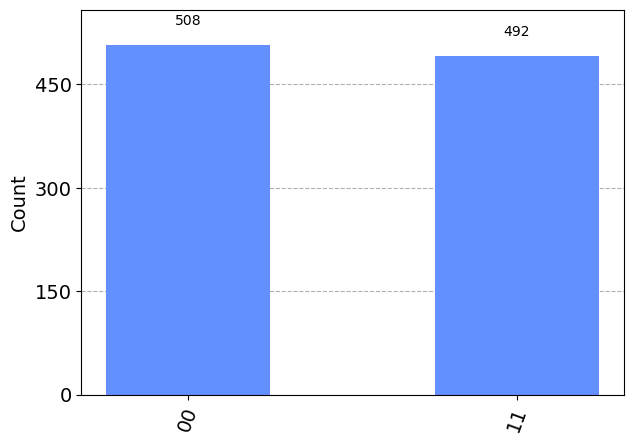

In [7]:
from qiskit import execute, BasicAer    
# previously in other examples is was referred as just Aer, 
# but now IBM separated noiseless and advanced backends.

job = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=1000)
counts = job.result().get_counts(qc)

plot_histogram(counts)

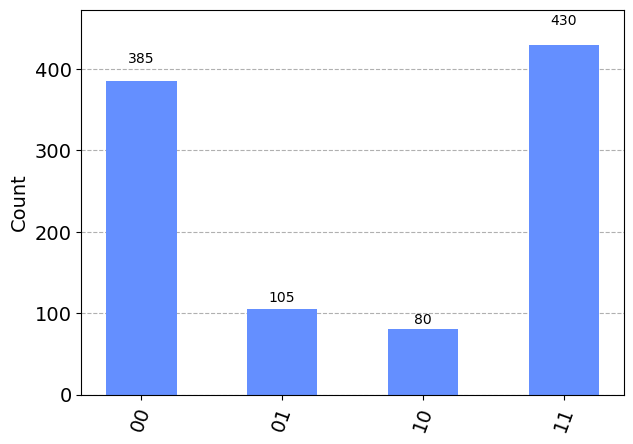

In [8]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer import noise

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

# from example https://qiskit.org/documentation/stubs/qiskit.providers.aer.noise.NoiseModel.html
noise_model = noise.NoiseModel()

# gates!
g1q = ['h', 'rx', 'ry', 'rz', 'x', 'y', 'z', 's']
g2q = ['cx']

# each qubit will have an error whe 1-qubit gate applies
for i in range(2):
    e = noise.depolarizing_error(0.01, 1)
    noise_model.add_quantum_error(e, g1q, [i])

# cx gates will have an error
for i, j in [[0, 1], [1, 0]]:
    e = noise.depolarizing_error(0.05, 2)
    noise_model.add_quantum_error(e, g2q, [i, j])

noise_model.add_readout_error(noise.ReadoutError([[0.9, 0.1], [0.1, 0.9]], 1), [0])
noise_model.add_readout_error(noise.ReadoutError([[0.9, 0.1], [0.1, 0.9]], 1), [1])
    

backend = AerSimulator(noise_model=noise_model)
job = execute(qc, backend, shots=1000)
counts = job.result().get_counts(qc)

plot_histogram(counts)

We don't have to invent error model if the provider specifies them:

In [ ]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qpu = provider.get_backend('ibmq_belem')
nm = NoiseModel.from_backend(qpu)

In [10]:
# nm.to_dict() -- this will print out the whole error config

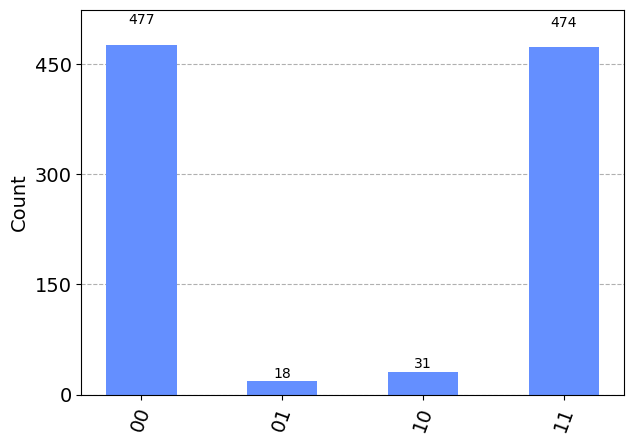

In [11]:
backend = AerSimulator(noise_model=nm)
job = execute(qc, backend, shots=1000)
counts = job.result().get_counts(qc)

plot_histogram(counts)

### And here is ideal vector state simulator. It runs once, but gives different results!

[0.+0.j 0.+0.j 0.+0.j 1.+0.j]


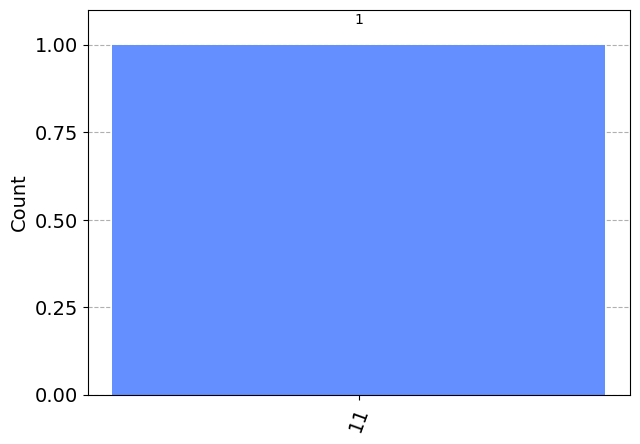

In [17]:
job = execute(qc, BasicAer.get_backend('statevector_simulator'))
result = job.result()
counts = result.get_counts(qc)

print(result.get_statevector(qc))
plot_histogram(counts)

And finally unitary matrix simulator. As measurements are not unitary, we will collect the same ciruit without measurements.

In [29]:
qru = QuantumRegister(2, 'qbits')
cru = ClassicalRegister(2, 'bits')
qcu = QuantumCircuit(qru, cru)

qcu.h(qru[0])
qcu.cx(qru[0], qru[1])

backend = BasicAer.get_backend('unitary_simulator')
# this will fail for the reason of default gate set:
# job = backend.run(qcu)
print(backend.configuration().basis_gates)
job = execute(qcu, backend)
result = job.result()

# Show the results
print(result.get_unitary(qcu, decimals=3))

['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'cx', 'id', 'unitary']
[[ 0.707+0.j  0.707-0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j -0.707+0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j  0.707-0.j]
 [ 0.707+0.j -0.707+0.j  0.   +0.j  0.   +0.j]]


# Real QPU

But the coolest is to run in real QPU, yes?

Visit https://quantum-computing.ibm.com/account and get the key!

In [ ]:
from qiskit import IBMQ
# IBMQ.save_account(open('token.ibm').read())

In [30]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2023-09-21 15:53:42,081: Credentials are already in use. The existing account in the session will be replaced.


In [31]:
available_cloud_backends = provider.backends() 
for backend in available_cloud_backends:
    status = backend.status()
    is_operational = status.operational
    jobs_in_queue = status.pending_jobs
    print(f"{backend}\t is online={is_operational}\twith a queue={jobs_in_queue}")

ibmq_qasm_simulator	 is online=True	with a queue=0
ibmq_lima	 is online=True	with a queue=12182
ibmq_belem	 is online=True	with a queue=492
ibmq_quito	 is online=True	with a queue=626
simulator_statevector	 is online=True	with a queue=0
simulator_mps	 is online=True	with a queue=0
simulator_extended_stabilizer	 is online=True	with a queue=0
simulator_stabilizer	 is online=True	with a queue=0
ibmq_jakarta	 is online=True	with a queue=1029
ibmq_manila	 is online=True	with a queue=4157
ibm_lagos	 is online=True	with a queue=212
ibm_nairobi	 is online=True	with a queue=1007
ibm_perth	 is online=True	with a queue=1082


Match these providers with https://quantum-computing.ibm.com/services?services=systems

In [32]:
qpu = provider.get_backend("ibm_lagos")
job = execute(qc, backend=qpu)

In [ ]:
from qiskit.tools.monitor import job_monitor
from time import time

start = time()
job_monitor(job)
end = time()

print(f"Time in a queue: {end - start:.2f} s")

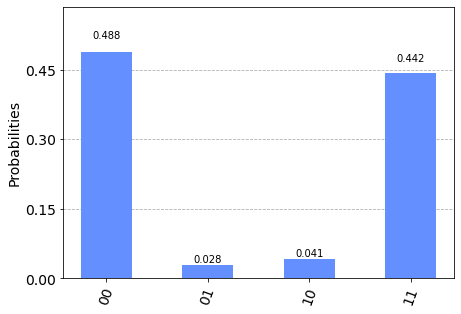

In [17]:
counts = job.result().get_counts()
plot_histogram(counts)